In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import squarify
import plotly
import plotly.graph_objects as go
import plotly.express as px


data_path = '../data/engineered_customer_data.csv'
df = pd.read_csv(data_path)

og_df = pd.read_csv('../data/cleaned_data.csv')

In [2]:
def get_rfm_score(df):

    df_ = df.copy()
    df_['Recency_Score'] = pd.qcut(df_['Recency'], 5, labels=[5, 4, 3, 2, 1])
    df_['Frequency_Score'] = pd.qcut(df_['Frequency'], 5, labels=[1, 2, 3, 4, 5])
    df_['Monetary_Score'] = pd.qcut(df_['Monetary'], 5, labels=[1, 2, 3, 4, 5])
    df_['RFM_Score'] = df_['Recency_Score'].astype(str) + df_['Frequency_Score'].astype(str) + df_['Monetary_Score'].astype(str)
    return df_

### Get RFM Score
- **Recency**: `Days_Since_Last_Transaction`
- **Frequency**: `Total_Transaction_Count`
- **Monetary**: `Total_Spent`

In [3]:
rfm_cols = ['CustomerID', 'Days_Since_Last_Transaction', 'Total_Transaction_Count', 'Total_Spent']
rfm_df = df[rfm_cols]

# Round monetary value to 3 decimal places
rfm_df.loc[:, 'Total_Spent'] = rfm_df['Total_Spent'].round(3)

# Remove rows with monetary value of 0
rfm_df = rfm_df[rfm_df['Total_Spent'] > 0]

# Rename columns
rfm_df.rename(columns={'Days_Since_Last_Transaction': 'Recency', 'Total_Transaction_Count': 'Frequency', 'Total_Spent': 'Monetary'}, inplace=True)

# Get RFM_Score:
rfm_df = get_rfm_score(rfm_df)
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
1,12347,2,182,4310.00,5,5,5,555
2,12348,75,27,1437.24,2,2,4,224
3,12349,18,72,1457.55,4,4,4,444
4,12350,310,16,294.40,1,2,2,122
5,12352,36,84,1265.41,3,4,4,344


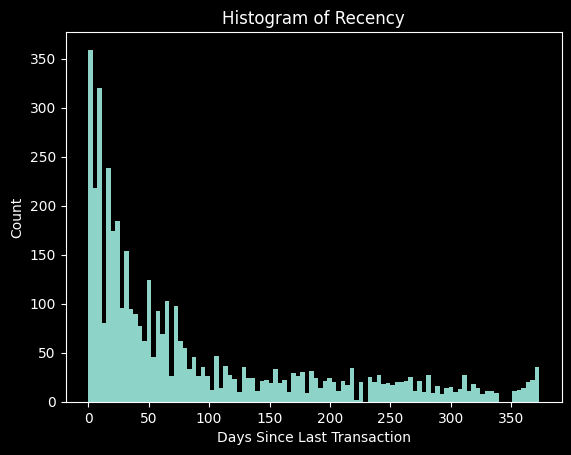

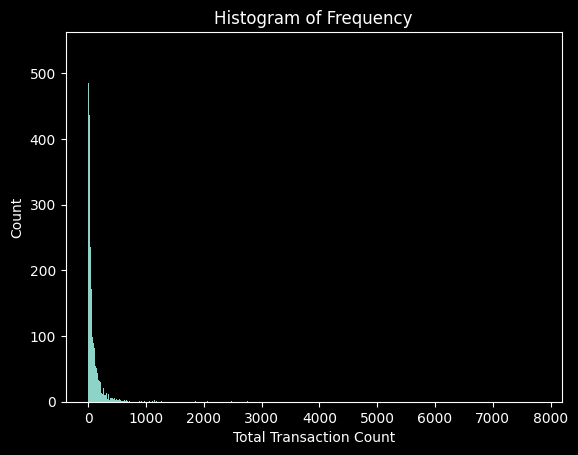

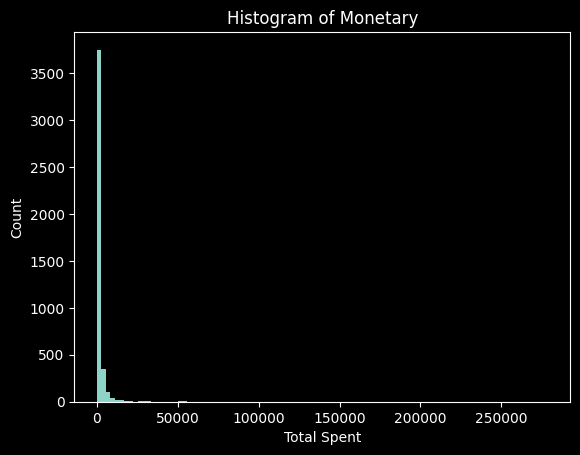

In [4]:
# plot histogram of Recency
plt.hist(rfm_df['Recency'], bins=100)
plt.title('Histogram of Recency')
plt.xlabel('Days Since Last Transaction')
plt.ylabel('Count')
plt.show()

# plot histogram of Frequency
plt.hist(rfm_df['Frequency'], bins=1000)
plt.title('Histogram of Frequency')
plt.xlabel('Total Transaction Count')
plt.ylabel('Count')
plt.show()

# plot histogram of Monetary
plt.hist(rfm_df['Monetary'], bins=100)
plt.title('Histogram of Monetary')
plt.xlabel('Total Spent')
plt.ylabel('Count')
plt.show()


### Use RFM Score to Segment Customers into Clusters
| Segment                      | Description                                            |
|------------------------------|--------------------------------------------------------|
| `Champions`                    | Bought recently, buy often and spend the most           |
| `Loyal Customers`              | Buy on a regular basis. Responsive to promotions.      |
| `Potential Loyalist`           | Recent customers with average frequency.               |
| `Recent Customers`             | Bought most recently, but not often.                   |
| `Promising`                    | Recent shoppers, but haven’t spent much.               |
| `Customers Needing Attention`  | Above average recency, frequency and monetary values.  |
| `About To Sleep`               | Below average recency and frequency. Will lose them if not reactivated. |
| `At Risk`                      | Purchased often but a long time ago. Need to bring them back! |
| `Can’t Lose Them`              | Used to purchase frequently but haven’t returned for a long time. |
| `Hibernating`                  | Last purchase was long back and low number of orders. May be lost. |


In [5]:
cluster_mapping = {r'[1-2][1-2]': 'Hibernating',
                   r'[1-2][3-4]': 'At Risk',
                   r'[1-2]5': 'Can\'t Lose',
                   r'3[1-2]': 'About to Sleep',
                   r'33': 'Need Attention',
                   r'[3-4][4-5]': 'Loyal Customers',
                   r'41': 'Promising',
                   r'51': 'New Customers',
                   r'[4-5][2-3]': 'Potential Loyalists',
                   r'5[4-5]': 'Champions'
                  }

rfm_df['RF_Segment'] = rfm_df['Recency_Score'].astype(str) + rfm_df['Frequency_Score'].astype(str)
rfm_df['Segment'] = rfm_df['RF_Segment'].replace(cluster_mapping, regex=True)

In [6]:
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,RF_Segment,Segment
1,12347,2,182,4310.00,5,5,5,555,55,Champions
2,12348,75,27,1437.24,2,2,4,224,22,Hibernating
3,12349,18,72,1457.55,4,4,4,444,44,Loyal Customers
4,12350,310,16,294.40,1,2,2,122,12,Hibernating
5,12352,36,84,1265.41,3,4,4,344,34,Loyal Customers


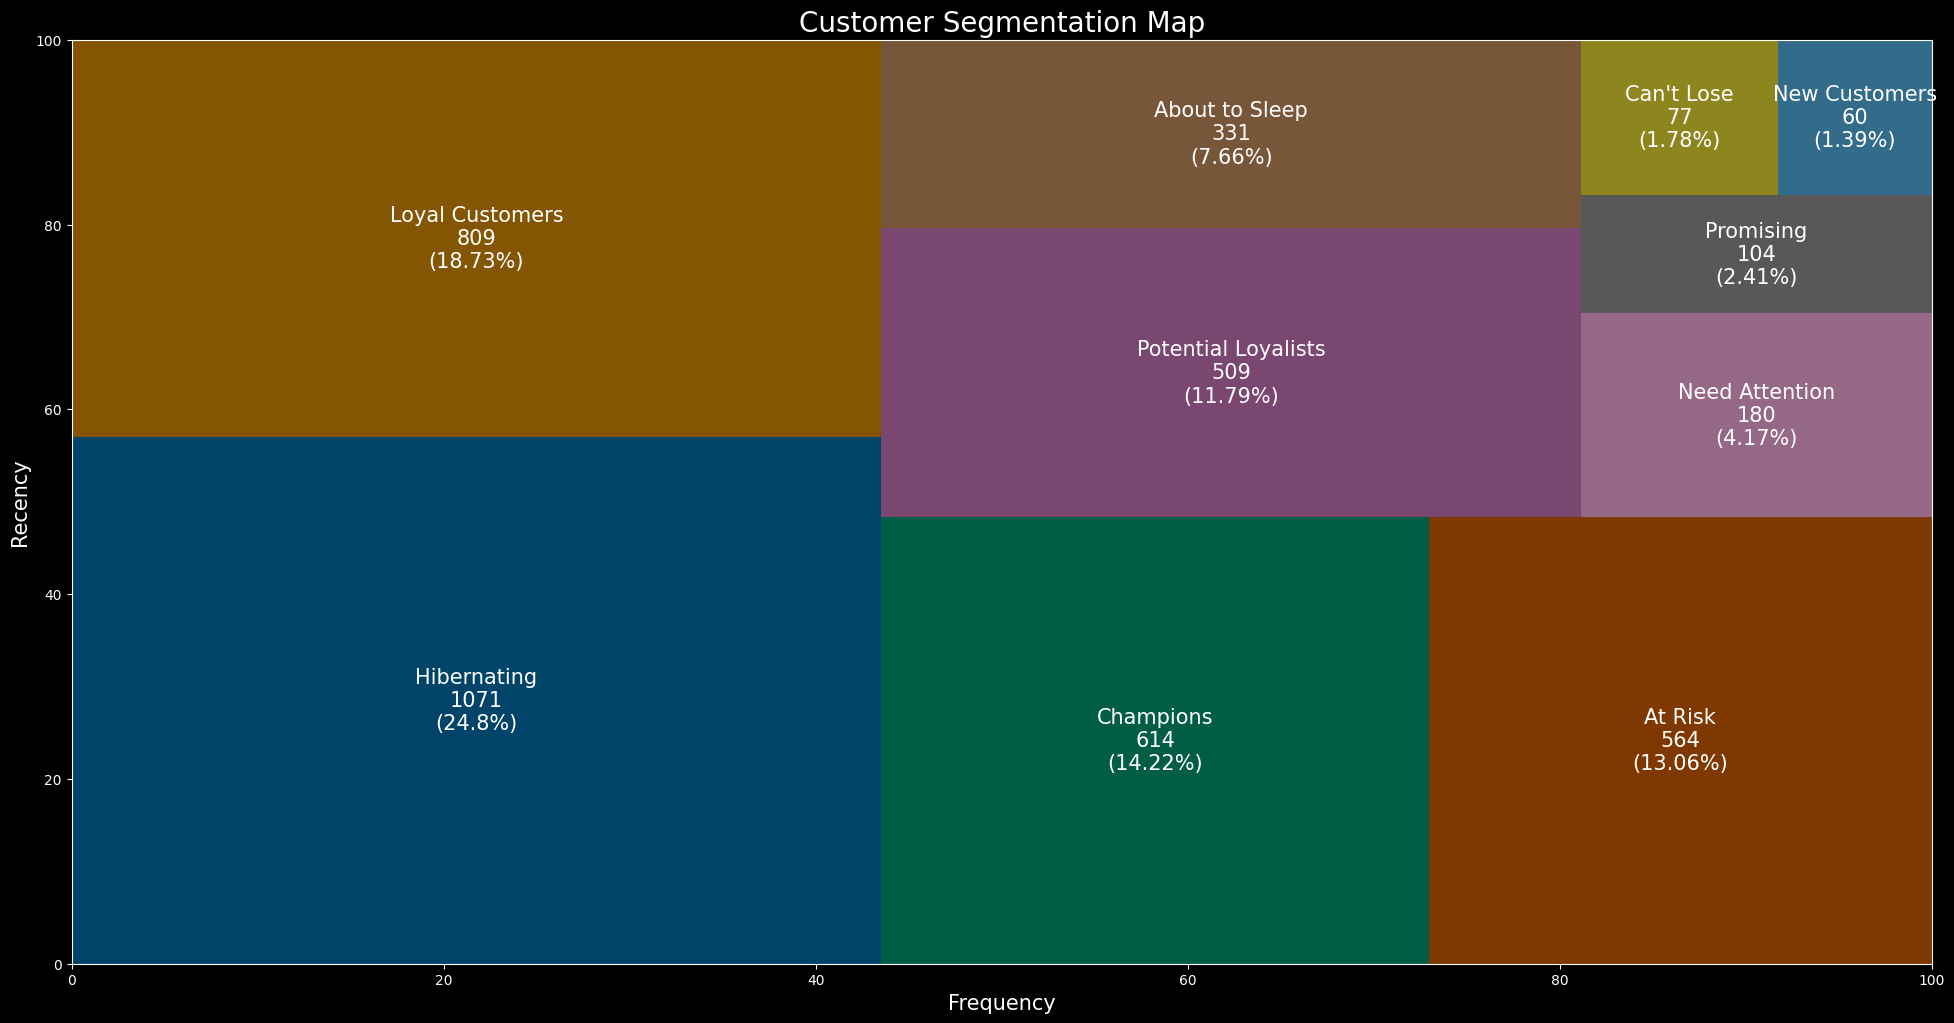

In [27]:
# Plot Customer Segmentation Map
segment_counts = rfm_df['Segment'].value_counts()
segment_pct = round(segment_counts / segment_counts.sum() * 100, 2)
label = segment_counts.index
label = label + '\n' + segment_counts.values.astype(str) + '\n' + '(' + segment_pct.astype(str) + '%' + ')'

segment_color = list(sns.color_palette('colorblind', 10).as_hex())
segment_color_mapping = {segment: segment_color[i] for i, segment in enumerate(segment_counts.index)}

fig = plt.gcf()
fig.set_size_inches(24, 12)
ax = fig.add_subplot()
squarify.plot(sizes=segment_counts.values, 
              label=label, 
              alpha=0.6, 
              color= segment_color,
              bar_kwargs={'alpha':.1}, 
              text_kwargs={'fontsize':15})

plt.title('Customer Segmentation Map', fontsize=20)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Recency', fontsize=15)
plt.show()

# save the plot in png format
fig.savefig('../reports/plots/customer_segmentation_map.png', dpi=200)

In [28]:
fig = px.scatter_3d(rfm_df, 
                    x='Recency',
                    y='Frequency', 
                    z='Monetary', 
                    color='Segment', 
                    color_discrete_map=segment_color_mapping)

# change the size of the figure
fig.update_layout(
    autosize=True,
    width=1000,
    height=800,
    # margin=dict(l=0, r=0, b=0, t=0),
)

# change the title of the figure
fig.update_layout(
    title={
        'text': 'Visualizing Customer RFM Segmentation',
        'y':0.955,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
        }
        )

fig.show()

# Export the plot
fig.write_html("../reports/plots/rfm_segmentation_3d.html")

# save the plot in png format
fig.write_image("../reports/plots/rfm_segmentation_3d.png")

In [9]:
# Plot RFM Segments using plotly
fig = go.Figure()

for segment in rfm_df['Segment'].unique():
    fig.add_trace(go.Scatter(x=rfm_df[rfm_df['Segment'] == segment]['Recency'],
                             y=rfm_df[rfm_df['Segment'] == segment]['Frequency'],
                             mode='markers',
                             name=segment,
                             marker=dict(size=10)))
    
fig.update_layout(
    title='Customer Segmentation',
    xaxis_title='Recency',
    yaxis_title='Frequency',
    width=1000,
    height=800
)
fig.show()


### Model Evaluation

In [10]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

print(' RFM Model Evaluation '.center(70, '-'))
X = rfm_df[['Recency_Score', 'Frequency_Score']]
labels = rfm_df['Segment']
print(f'Number of Observations: {X.shape[0]}')
print(f'Number of Segments: {labels.nunique()}')
print(f'Silhouette Score: {round(silhouette_score(X, labels), 3)}')
print(f'Calinski Harabasz Score: {round(calinski_harabasz_score(X, labels), 3)}')
print(f'Davies Bouldin Score: {round(davies_bouldin_score(X, labels), 3)} \n{70*"="}')

------------------------ RFM Model Evaluation ------------------------
Number of Observations: 4319
Number of Segments: 10
Silhouette Score: 0.464
Calinski Harabasz Score: 4520.091
Davies Bouldin Score: 0.643 


### Visualizing Customer Segment Behavior with Radar Chart 

In [11]:
# Merge rfm and original data
rfm_df = rfm_df.merge(df, on='CustomerID')

In [21]:
# Create a horizontal boxplot for Recency of each segment using plotly express
fig = px.box(rfm_df, 
             x='Recency', 
             y='Segment', 
             orientation='h', 
             title='Recency Distribution by Segment', 
             color='Segment',
             color_discrete_map=segment_color_mapping, 
             width=900,
             height=600)

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=14,
        # font_family="Rockwell",
    )
)
fig.show()

# save the plot
fig.write_html("../reports/plots/recency_distribution_by_segment.html")

# save the plot in png format
fig.write_image("../reports/plots/recency_distribution_by_segment.png")

In [22]:
# Create a horizontal boxplot for Frequency of each segment using plotly express
fig = px.box(rfm_df, 
             x='Frequency', 
             y='Segment', 
             orientation='h', 
             title='Frequency Distribution by Segment', 
             color='Segment',
             color_discrete_map=segment_color_mapping, 
             width=900,
             height=600)

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=14,
        # font_family="Rockwell",
    )
)
fig.show()

# save the plot
fig.write_html("../reports/plots/frequency_distribution_by_segment.html")

# save the plot in png format
fig.write_image("../reports/plots/frequency_distribution_by_segment.png")

In [23]:
# Create a horizontal boxplot for Monetary of each segment using plotly express
fig = px.box(rfm_df, 
             x='Monetary', 
             y='Segment', 
             orientation='h', 
             title='Monetary Distribution by Segment', 
             color='Segment',
             color_discrete_map=segment_color_mapping, 
             width=900,
             height=600)

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=14,
        # font_family="Rockwell",
    )
)
fig.show()

# save the plot
fig.write_html("../reports/plots/monetary_distribution_by_segment.html")

# save the plot in png format
fig.write_image("../reports/plots/monetary_distribution_by_segment.png")

### Customer Lifetime Value

In [15]:
rfm_df.columns

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Recency_Score',
       'Frequency_Score', 'Monetary_Score', 'RFM_Score', 'RF_Segment',
       'Segment', 'Days_Since_Last_Transaction', 'Total_Orders_Count',
       'Total_Prod_Purchased', 'Total_Spent', 'Avg_Order_Value',
       'Uniq_Prod_Purchased_Count', 'Avg_Days_Btw_Order', 'Fav_DoW',
       'Fav_Hour', 'is_UK', 'Cancellation_Count', 'Total_Transaction_Count',
       'Cancellation_Rate', 'Avg_Monthly_Spending', 'Std_Monthly_Spending',
       'Monthly_Spending_Trend'],
      dtype='object')

In [16]:
cols = ['CustomerID', 'Segment', 'Total_Orders_Count', 'Avg_Order_Value', 'Avg_Days_Btw_Order', 'Avg_Monthly_Spending', 'Monthly_Spending_Trend']
rfm_df[cols].head()

,CustomerID,Segment,Total_Orders_Count,Avg_Order_Value,Avg_Days_Btw_Order,Avg_Monthly_Spending,Monthly_Spending_Trend
0,12347,Champions,7,615.714,60.83,615.714,4.486071
1,12348,Hibernating,4,359.310,94.33,359.310,-100.884000
2,12349,Loyal Customers,1,1457.550,0.00,1457.550,0.000000
3,12350,Hibernating,1,294.400,0.00,294.400,0.000000
4,12352,Loyal Customers,8,158.176,69.43,316.352,9.351000


In [17]:
rfm_df['Frequency']

0       182
1        27
2        72
3        16
4        84
       ... 
4314     10
4315      7
4316     13
4317    719
4318     70
Name: Frequency, Length: 4319, dtype: int64

In [18]:
# Calculate Customer Lifetime Value (CLV) for each segment

# Compute customer value:
rfm_df['Customer_Value'] = rfm_df['Total_Orders_Count'] * rfm_df['Avg_Order_Value']

# Compute customer value by segment:
clv_by_segment = rfm_df.groupby('Segment')['Customer_Value'].mean().reset_index().sort_values(by='Customer_Value', ascending=False)

In [19]:
# plot Customer Value by Segment
fig = px.bar(clv_by_segment, 
             x='Segment', 
             y='Customer_Value', 
             title='Customer Value by Segment',
             color='Segment',
             color_discrete_map=segment_color_mapping,
             width=900,
             height=600)
fig.show()

# save the plot
fig.write_html("../reports/plots/customer_value_by_segment.html")

In [20]:
# save the plot in png format
fig.write_image("../reports/plots/customer_value_by_segment.png")